In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca2140.jp

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

import os
import datetime
import shutil
import itertools
import random
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [3]:
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
classes = ['colon_aca', 'colon_n']

split_dir = 'split_colon_images'

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

def split_and_copy_images(class_dir, class_name):
    all_images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42, shuffle=True)

    val_images, test_images = train_test_split(temp_images, test_size=2/3, random_state=42, shuffle=True)

    def copy_images(images, dest):
        for img in images:
            src_path = os.path.join(class_dir, img)
            dst_path = os.path.join(split_dir, dest, class_name, img)
            shutil.copy(src_path, dst_path)

    copy_images(train_images, 'train')
    copy_images(val_images, 'val')
    copy_images(test_images, 'test')

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    split_and_copy_images(class_path, cls)

print("Images have been split into training, validation, and testing sets.")


Images have been split into training, validation, and testing sets.


Displaying images from: train


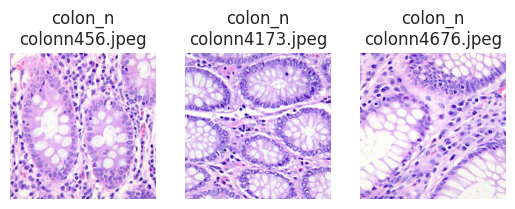

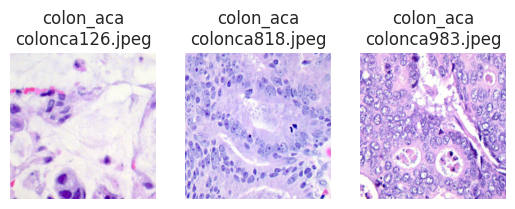

Displaying images from: val


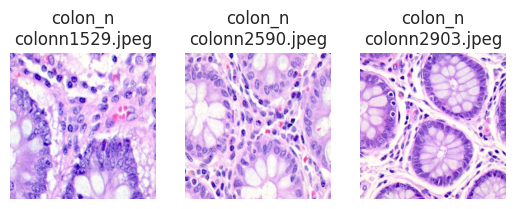

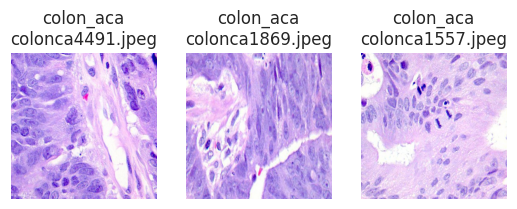

Displaying images from: test


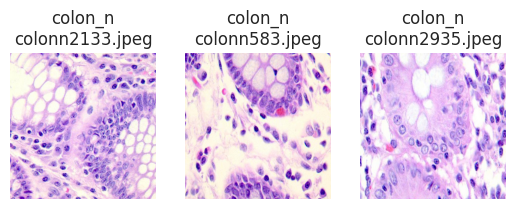

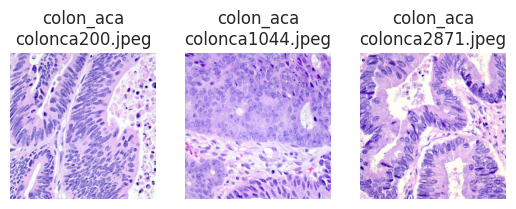

In [4]:


base_dir = 'split_colon_images'

def display_random_images(base_dir, num_images=3):
    for split in ['train', 'val', 'test']:
        print(f"Displaying images from: {split}")
        split_dir = os.path.join(base_dir, split)
        for cls in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, cls)
            image_files = os.listdir(class_dir)
            random_images = random.sample(image_files, num_images)
            for i, img_name in enumerate(random_images):
                img_path = os.path.join(class_dir, img_name)
                img = Image.open(img_path)
                plt.subplot(1, num_images, i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'{cls}\n{img_name}')
            plt.show()


display_random_images(base_dir)


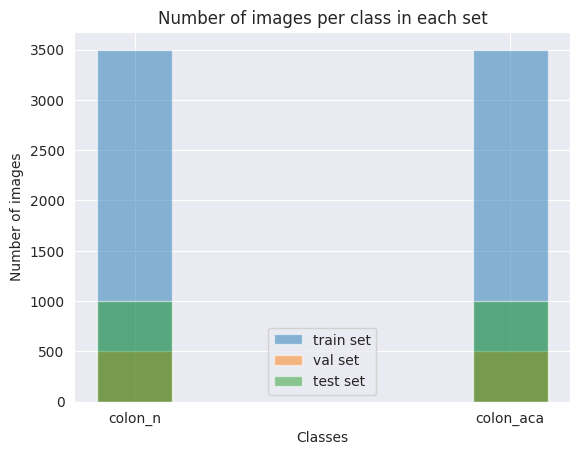

In [5]:
def plot_image_counts(base_dir):
    counts = {}
    for split in ['train', 'val', 'test']:
        counts[split] = {}
        split_dir = os.path.join(base_dir, split)
        for cls in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, cls)
            counts[split][cls] = len(os.listdir(class_dir))

    fig, ax = plt.subplots()
    for i, split in enumerate(['train', 'val', 'test']):
        sub_counts = counts[split]
        ax.bar(range(len(sub_counts)), sub_counts.values(), width=0.2, align='center', alpha=0.5, label=f'{split} set')
        ax.set_xticks(range(len(sub_counts)))
        ax.set_xticklabels(sub_counts.keys())
        ax.set_xlabel('Classes')
        ax.set_ylabel('Number of images')
        ax.set_title('Number of images per class in each set')
        ax.legend()

    plt.show()
    

plot_image_counts(base_dir)

In [6]:
base_dir = 'split_colon_images'

def count_images(base_dir):
    image_counts = {'train': 0, 'val': 0, 'test': 0}
    
    for split in image_counts.keys():
        split_dir = os.path.join(base_dir, split)
        for cls in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, cls)
            image_counts[split] += len([img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    for split, count in image_counts.items():
        print(f"Number of images in {split}: {count}")

count_images(base_dir)


Number of images in train: 7000
Number of images in val: 1000
Number of images in test: 2000


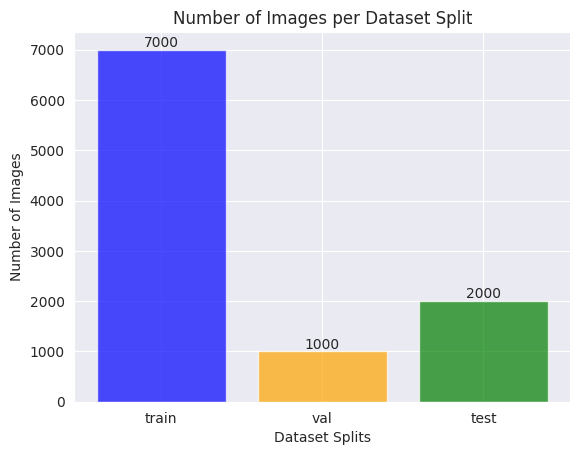

In [7]:
base_dir = 'split_colon_images'

image_counts = {}

splits = ['train', 'val', 'test']

for split in splits:
    split_dir = os.path.join(base_dir, split)
    image_counts[split] = sum([len(files) for r, d, files in os.walk(split_dir)])


bar_locations = range(len(image_counts))

plt.bar(bar_locations, image_counts.values(), align='center', alpha=0.7, color=['blue', 'orange', 'green'])

for i, count in enumerate(image_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(bar_locations, image_counts.keys())

plt.xlabel('Dataset Splits')
plt.ylabel('Number of Images')
plt.title('Number of Images per Dataset Split')

plt.show()


In [8]:

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255 
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  


Found 7000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:


def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def encoder_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it and then perform max pooling"""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function to upsample, concatenate and then add 2 convolutional layers"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, n_classes):
    """Function to build a U-Net using the building blocks defined above"""
    inputs = Input(input_shape)

    # encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # bridge
    b = conv_block(p4, 1024)

    # decoder
    d1 = decoder_block(b, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)


    # Output
    outputs = Conv2D(n_classes, (1, 1), padding='same')(d4)
    outputs = Flatten()(outputs)
    outputs = Dense(n_classes, activation='softmax')(outputs)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (224, 224, 3) 
n_classes = 2  

model_colon = build_unet(input_shape, n_classes)

model_colon.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model_colon.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:


def create_callbacks(early_stop_patience=5, reduce_lr_patience=2, model_checkpoint_path='model_colon_2.h5'):
    """
    Creates a list of callbacks for training.

    Parameters:
    - early_stop_patience: Number of epochs with no improvement after which training will be stopped.
    - reduce_lr_patience: Number of epochs with no improvement after which learning rate will be reduced.
    - model_checkpoint_path: Path to save the model file.

    Returns:
    - List of callbacks.
    """

    # EarlyStopping callback
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=early_stop_patience,
                               verbose=1,
                               restore_best_weights=True)

    # ModelCheckpoint callback
    checkpoint = ModelCheckpoint(model_checkpoint_path,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='min')

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.1,
                                  patience=reduce_lr_patience,
                                  verbose=1,
                                  mode='min',
                                  min_delta=0.0001,
                                  cooldown=0,
                                  min_lr=0)

    # TensorBoard callback
    log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

    return [early_stop, checkpoint, reduce_lr, tensorboard]

callbacks_list = create_callbacks()



In [13]:
print(train_gen.samples)

7000


In [14]:
batch_size = 40   
epochs = 35   
patience = 1   
stop_patience = 3   
threshold = 0.9   
factor = 0.5   
ask_epoch = 5   
train_batches = int(np.ceil(len(train_gen.labels) / batch_size))
valid_batches = int(np.ceil(len(valid_gen.labels) / batch_size))


In [15]:
history = model_colon.fit(x=train_gen, steps_per_epoch=train_batches, epochs=epochs, validation_data=valid_gen, validation_steps=valid_batches,
                          callbacks=callbacks_list, verbose=1, shuffle= False)

Epoch 1/35
175/175 [==============================] - ETA: 0s - loss: 0.9069 - accuracy: 0.8405
Epoch 1: val_loss improved from inf to 5.80565, saving model to model_colon_2.h5
175/175 [==============================] - 150s 660ms/step - loss: 0.9069 - accuracy: 0.8405 - val_loss: 5.8056 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 2/35
175/175 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9459
Epoch 2: val_loss did not improve from 5.80565
175/175 [==============================] - 114s 650ms/step - loss: 0.1769 - accuracy: 0.9459 - val_loss: 12.2609 - val_accuracy: 0.5013 - lr: 0.0010
Epoch 3/35
175/175 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9750
Epoch 3: val_loss did not improve from 5.80565

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
175/175 [==============================] - 114s 650ms/step - loss: 0.0835 - accuracy: 0.9750 - val_loss: 7.5127 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 4/35
175

In [16]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [17]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

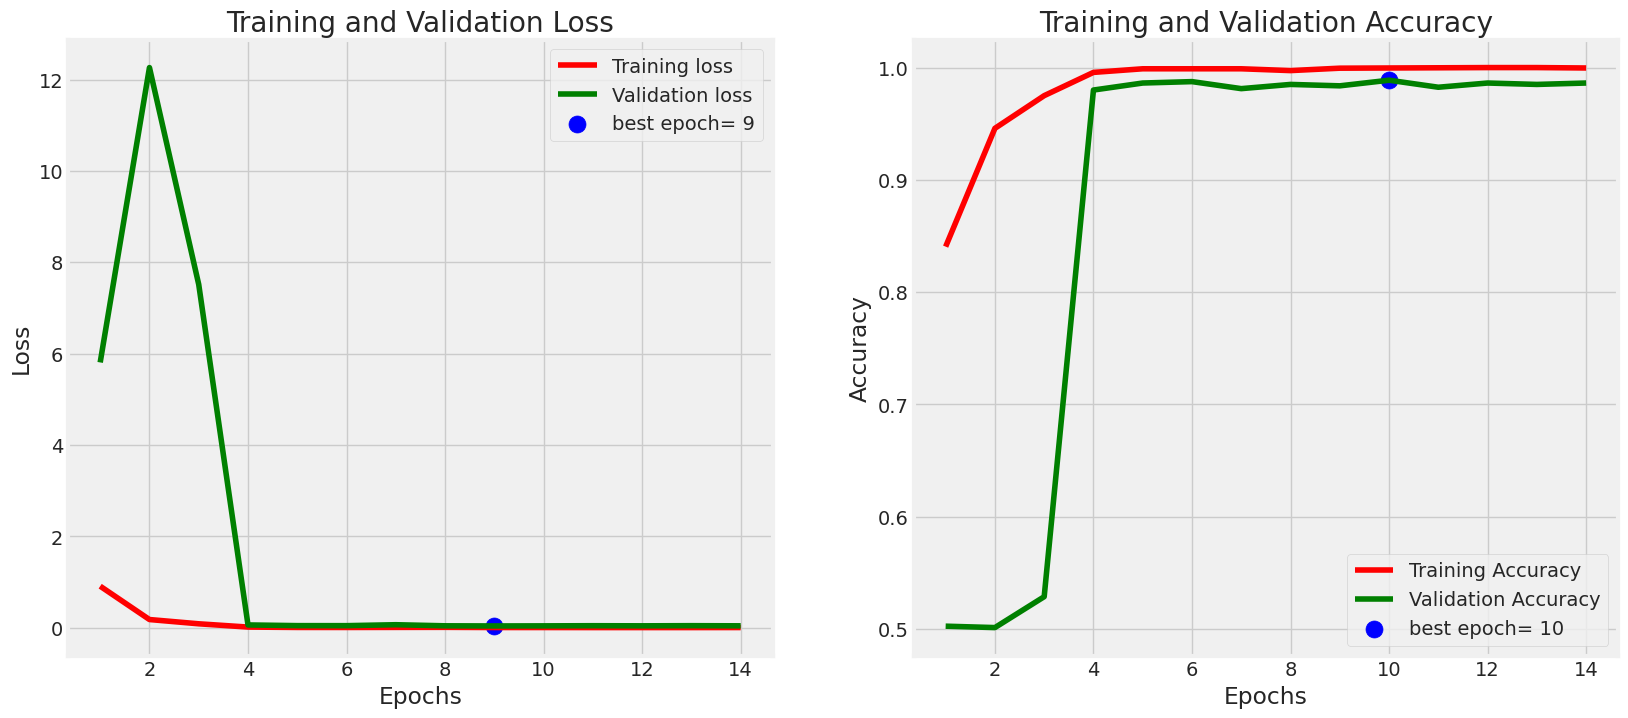

In [18]:
plot_training(history)

In [19]:
ts_length = 2000
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_colon.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_colon.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_colon.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 5s 200ms/step - loss: 0.0566 - accuracy: 0.9837
Train Loss:  0.00014399153587874025
Train Accuracy:  1.0
--------------------
Validation Loss:  0.040851835161447525
Validation Accuracy:  0.9837499856948853
--------------------
Test Loss:  0.056579023599624634
Test Accuracy:  0.9837499856948853


In [20]:
test_loss, test_accuracy = model_colon.evaluate(
    test_gen,
    steps=test_gen.samples // test_gen.batch_size
)

print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

62/62 [==============================] - 12s 199ms/step - loss: 0.0370 - accuracy: 0.9889
Test loss: 0.0369730070233345, Test accuracy: 0.9889112710952759


In [22]:
model = load_model("model_colon_2.h5")

test_loss, test_accuracy = model.evaluate(test_gen, steps=test_gen.samples // test_gen.batch_size)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


62/62 [==============================] - 13s 198ms/step - loss: 0.0370 - accuracy: 0.9889
Test loss: 0.0369730070233345, Test accuracy: 0.9889112710952759


In [23]:
predictions = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size)

predicted_class_indices = np.argmax(predictions, axis=-1) 
if test_gen.class_indices:
    labels = (test_gen.class_indices)
    labels = dict((v, k) for k, v in labels.items()) 
    predictions_labels = [labels[k] for k in predicted_class_indices]
for i in range(10):
    actual_label = test_gen.filenames[i].split('/')[0]
    predicted_label = predictions_labels[i]
    print(f'Actual label: {actual_label}, Predicted label: {predicted_label}')

62/62 [==============================] - 12s 194ms/step
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca
Actual label: colon_aca, Predicted label: colon_aca


[0 0 0 ... 1 1 1]
Confusion Matrix, Without Normalization
[[985  15]
 [  7 993]]
              precision    recall  f1-score   support

   colon_aca       0.99      0.98      0.99      1000
     colon_n       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



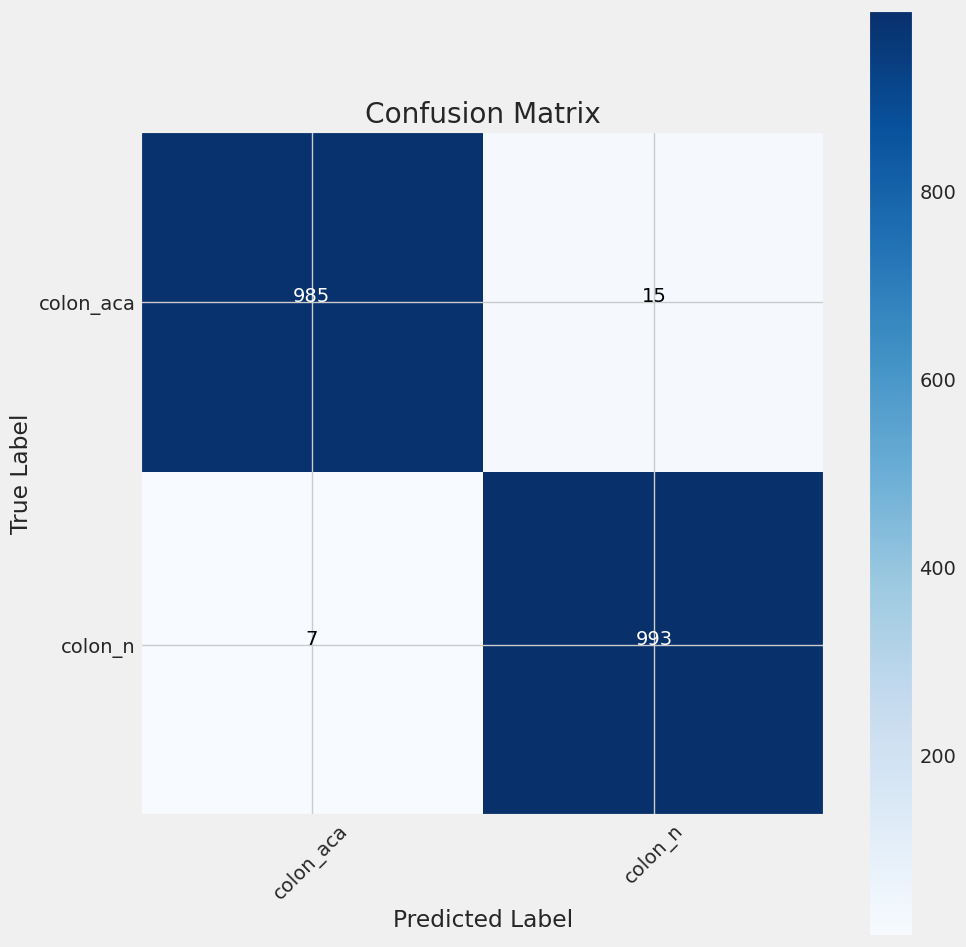

In [24]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [25]:


model = load_model("/kaggle/working/model_colon_2.h5")

def predict_image_class(img_path, model, image_size=(224, 224)):
    img = image.load_img(img_path, target_size=image_size)
    
    img_array = image.img_to_array(img)
    
    img_array = img_array / 255.0
    
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)
    
    predicted_class_index = np.argmax(predictions, axis=-1)
    
    label_map = (train_gen.class_indices) 
    label_map = dict((v, k) for k, v in label_map.items())
    
    predicted_class_label = label_map[predicted_class_index[0]]
    
    return predicted_class_label

new_image_path = '/kaggle/working/split_colon_images/train/colon_aca/colonca2910.jpeg'

predicted_class = predict_image_class(new_image_path, model)
print(f'The image belongs to class: {predicted_class}')


1/1 [==============================] - 1s 1s/step
The image belongs to class: colon_aca


In [26]:


model_path = 'model_colon_2.h5'
model = load_model(model_path)

test_dir = os.path.join(base_dir, 'test')

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

class_names = os.listdir(test_dir)

random_class_name = random.choice(class_names)

image_files = os.listdir(os.path.join(test_dir, random_class_name))

random_image_file = random.choice(image_files)

random_image_path = os.path.join(test_dir, random_class_name, random_image_file)

img_array = preprocess_image(random_image_path)

prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

class_indices = {'colon_aca': 0, 'colon_n': 1}

predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index[0])]

print(f"Selected image path: {random_image_path}")
print(f"Actual class: {random_class_name}")
print(f"Predicted class: {predicted_class_name}")


1/1 [==============================] - 0s 417ms/step
Selected image path: split_colon_images/test/colon_n/colonn2853.jpeg
Actual class: colon_n
Predicted class: colon_n


In [27]:
model_path = 'model_colon_2.h5'
model = load_model(model_path)

test_dir = os.path.join(base_dir, 'test')

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 
    return img_array

class_names = os.listdir(test_dir)

results = []

for _ in range(10):
    random_class_name = random.choice(class_names)

    image_files = os.listdir(os.path.join(test_dir, random_class_name))

    random_image_file = random.choice(image_files)

    random_image_path = os.path.join(test_dir, random_class_name, random_image_file)

    img_array = preprocess_image(random_image_path)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)

    class_indices = {'colon_aca': 0, 'colon_n': 1}

    predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index[0])]

    results.append((random_image_path, random_class_name, predicted_class_name))

for img_path, actual, predicted in results:
    print(f"Selected image path: {img_path}")
    print(f"Actual class: {actual}")
    print(f"Predicted class: {predicted}")
    print('---')


1/1 [==============================] - 0s 20ms/step
Selected image path: split_colon_images/test/colon_n/colonn2473.jpeg
Actual class: colon_n
Predicted class: colon_n
---
Selected image path: split_colon_images/test/colon_aca/colonca5000.jpeg
Actual class: colon_aca
Predicted class: colon_aca
---
Selected image path: split_colon_images/test/colon_n/colonn3778.jpeg
Actual class: colon_n
Predicted class: colon_n
---
Selected image path: split_colon_images/test/colon_aca/colonca2089.jpeg
Actual class: colon_aca
Predicted class: colon_aca
---
Selected image path: split_colon_images/test/colon_aca/colonca2158.jpeg
Actual class: colon_aca
Predicted class: colon_aca
---
Selected image path: split_colon_images/test/colon_aca/colonca3390.jpeg
Actual class: colon_aca
Predicted class: colon_aca
---
Selected image path: split_colon_images/test/colon_n/colonn1930.jpeg
Actual class: colon_n
Predicted class: colon_n
---
Selected image path: split_colon_images/test/colon_aca/colonca4395.jpeg
Actual c